Petit test markdown

Imports

In [78]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

#import de Bokeh pour les cartes
from bokeh.io import output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.io import output_notebook, show, output_file
from bokeh.io import export_png
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, HoverTool, BoxZoomTool, ResetTool, SaveTool
from bokeh.palettes import brewer
output_notebook()
import json

#import pour l'API
import requests

Loading BokehJS ...

In [79]:
url="https://drive.google.com/file/d/1GGOLMc_Ow9yZC9sICegPegDggQuHOD3t/view?usp=drive_link"
url="https://drive.google.com/uc?export=download&confirm=1&id=" + url.split("/")[-2]
base = pd.read_csv(url)

Premier avant-goût de la base

In [80]:
pd.set_option('display.max_columns', None)
base.sample(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
119368,534315,2016-04-02,Alabama,Enterprise,500 block of Fleming Street,0,1,http://www.gunviolencearchive.org/incident/534315,http://www.wsfa.com/story/31637196/enterprise-...,False,2.0,NaN,NaN,Shot - Wounded/Injured,31.3131,NaN,-85.8653,NaN,NaN,NaN,0::Adult 18+||1::Teen 12-17,NaN,NaN,NaN,"0::Injured||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,http://www.wsfa.com/story/31637196/enterprise-...,91.0,31.0
61107,307547,2015-03-15,Texas,El Paso,Montana Ave. and N. Laurel St.,0,0,http://www.gunviolencearchive.org/incident/307547,http://www.ktsm.com/news/crimebeat/police-inve...,False,16.0,NaN,NaN,Shots Fired - No Injuries||Institution/Group/B...,31.7753,NaN,-106.4740,NaN,El Paso police investigating this report of sh...,NaN,0::Adult 18+,0::Male,NaN,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,http://www.ktsm.com/news/crimebeat/police-inve...,77.0,29.0
58741,808602,2015-02-25,Ohio,Warren,NaN,0,0,http://www.gunviolencearchive.org/incident/808602,https://www.justice.gov/usao-ndoh/pr/warren-ma...,False,NaN,0::Unknown||1::Unknown,0::Unknown||1::Unknown,Non-Shooting Incident||Drug involvement||ATF/L...,NaN,NaN,NaN,2.0,NaN,0::31,0::Adult 18+,0::Male,0::Ricardo B. McKinney,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,https://www.justice.gov/usao-ndoh/pr/warren-ma...,NaN,NaN
74456,355989,2015-06-10,Florida,Fort Lauderdale (Lauderhill),Northwest 21st Street,0,2,http://www.gunviolencearchive.org/incident/355989,http://www.local10.com/news/1-in-custody-after...,False,23.0,NaN,NaN,Shot - Wounded/Injured,26.1506,Calypso Cay Apartments,-80.3300,NaN,NaN,NaN,0::Adult 18+||1::Adult 18+,0::Male||1::Male,NaN,NaN,0::Injured||1::Injured,0::Victim||1::Victim,http://www.local10.com/news/1-in-custody-after...,97.0,29.0
127416,565778,2016-05-23,Maine,Augusta,Boothby Street,0,1,http://www.gunviolencearchive.org/incident/565778,http://www.centralmaine.com/2016/05/24/person-...,False,1.0,NaN,NaN,Shot - Wounded/Injured,44.3203,NaN,-69.7761,NaN,NaN,NaN,0::Adult 18+,0::Male,NaN,NaN,0::Injured,0::Victim,http://www.centralmaine.com/2016/05/24/person-...,57.0,24.0


Ici, nécessaire de convertir toutes les colonnes à un format manipulable : dictionnaires

In [81]:
def convert_to_dict(value):
    if pd.isna(value):
        return value

    pairs = value.split('||')
    result_dict = {}
    for pair in pairs:
        #Some are corrupted : 1: instead of ::
        if '::' in pair:
            key, val = pair.split('::', 1)
            result_dict[int(key)] = val
        else:
            key, val = pair.split(':', 1)
            result_dict[int(key)] = val
    return result_dict

updated_base = base.copy()
list_of_dict_columns = ['gun_stolen', 'gun_type', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_name', 'participant_relationship', 'participant_status', 'participant_type']
updated_base[list_of_dict_columns] = updated_base[list_of_dict_columns].applymap(convert_to_dict)
updated_base.head()



/tmp/ipykernel_17817/3116768970.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  updated_base[list_of_dict_columns] = updated_base[list_of_dict_columns].applymap(convert_to_dict)


,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,congressional_district,gun_stolen,gun_type,incident_characteristics,latitude,location_description,longitude,n_guns_involved,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,40.3467,NaN,-79.8559,NaN,Julian Sims under investigation: Four Shot and...,{0: '20'},"{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...","{0: 'Male', 1: 'Male', 3: 'Male', 4: 'Female'}",{0: 'Julian Sims'},NaN,"{0: 'Arrested', 1: 'Injured', 2: 'Injured', 3:...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Vi...",http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",33.9090,NaN,-118.3330,NaN,Four Shot; One Killed; Unidentified shooter in...,{0: '20'},"{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...",{0: 'Male'},{0: 'Bernard Gillis'},NaN,"{0: 'Killed', 1: 'Injured', 2: 'Injured', 3: '...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Vi...",http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,9.0,"{0: 'Unknown', 1: 'Unknown'}","{0: 'Unknown', 1: 'Unknown'}","Shot - Wounded/Injured||Shot - Dead (murder, a...",41.4455,Cotton Club,-82.1377,2.0,NaN,"{0: '25', 1: '31', 2: '33', 3: '34', 4: '33'}","{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...","{0: 'Male', 1: 'Male', 2: 'Male', 3: 'Male', 4...","{0: 'Damien Bell', 1: 'Desmen Noble', 2: 'Herm...",NaN,"{0: 'Injured, Unharmed, Arrested', 1: 'Unharme...","{0: 'Subject-Suspect', 1: 'Subject-Suspect', 2...",http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,6.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",39.6518,NaN,-104.8020,NaN,NaN,"{0: '29', 1: '33', 2: '56', 3: '33'}","{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Adult 18+...","{0: 'Female', 1: 'Male', 2: 'Male', 3: 'Male'}","{0: 'Stacie Philbrook', 1: 'Christopher Ratlif...",NaN,"{0: 'Killed', 1: 'Killed', 2: 'Killed', 3: 'Ki...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Su...",http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,6.0,"{0: 'Unknown', 1: 'Unknown'}","{0: 'Handgun', 1: 'Handgun'}","Shot - Wounded/Injured||Shot - Dead (murder, a...",36.1140,NaN,-79.9569,2.0,Two firearms recovered. (Attempted) murder sui...,"{0: '18', 1: '46', 2: '14', 3: '47'}","{0: 'Adult 18+', 1: 'Adult 18+', 2: 'Teen 12-1...","{0: 'Female', 1: 'Male', 2: 'Male', 3: 'Female'}","{0: 'Danielle Imani Jameison', 1: 'Maurice Eug...",{3: 'Family'},"{0: 'Injured', 1: 'Injured', 2: 'Killed', 3: '...","{0: 'Victim', 1: 'Victim', 2: 'Victim', 3: 'Su...",http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


Première représentation graphique des incidents de la base

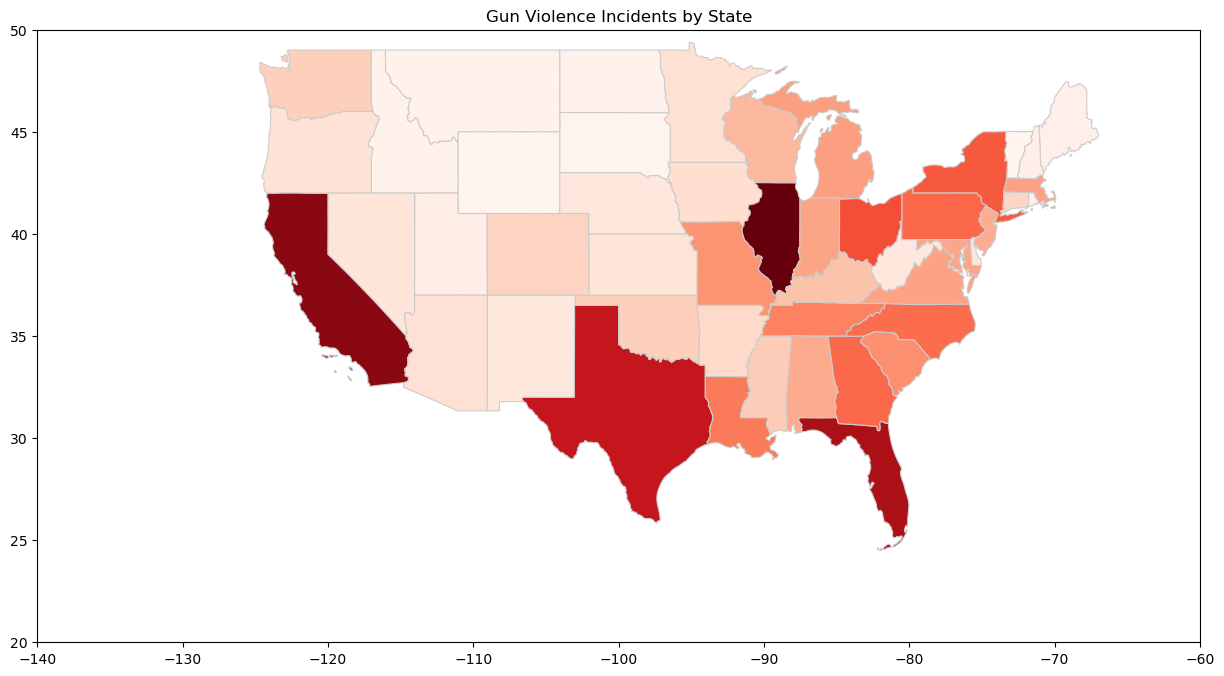

In [82]:
us_states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip')

incident_counts = updated_base.groupby('state')['incident_id'].count().reset_index()
us_states = us_states.merge(incident_counts, left_on='NAME', right_on='state', how='left')

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
us_states.plot(column='incident_id', cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

# Add a title and show the plot
plt.title('Gun Violence Incidents by State')
ax.set_xlim([-140, -60])  # Adjust these values based on your preference
ax.set_ylim([20, 50]) 


plt.show()

Carte interactive

In [83]:
drop_state = ["AS", "AK", "HI", "GU", "VI", "MP", "PR"] #to keep the continental USA
us_states = us_states[~us_states["STUSPS"].isin(drop_state)]

In [84]:
us_states_geojson = us_states[["state", "geometry", "incident_id"]].rename(columns= {"incident_id" : "nb_incidents"})
us_states_geojson = GeoJSONDataSource(geojson = us_states_geojson.to_json())

In [85]:
color_mapper = LinearColorMapper(palette = brewer['RdBu'][10], low = 400, high = 20000)
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 530, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
save = SaveTool()
hover = HoverTool(tooltips = [ ("State","@state"),("Nb d'incidents", "@nb_incidents")])
p = figure(title="Nombre d'incidents par Etats", tools=[hover, save], width=600, height=350)
p.patches("xs","ys",source=us_states_geojson, fill_color = {"field" :"nb_incidents", "transform" : color_mapper})
p.add_layout(color_bar, 'above')
p.axis.visible = False
show(p)
#export_png(p, filename="plot.png", width = 600, height = 350)

Fred Api to get data series about the counties

In [86]:
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

In [87]:
api_key = "180de2e6a1d1e953d270ebf38341cd44"
param = {"api_key" : api_key, "file_type" : "json", "category_id" : "27281"}
url = "https://api.stlouisfed.org/fred/category/children?"
response = requests.get(url, params=param)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    data = response.json()
    # Process the data as needed
else:
    print(f"Error: {response.status_code}, {response.text}")

liste = data["categories"] #on rentre dans le premier dictionnaire
dico_id_states = dict()

for dic in liste : #on parcourt la liste en stockant dans un dictionnaire le nom de l'état et le numéro de la catégorie associée
    dico_id_states[dic["name"]] = dic["id"]

In [88]:
state_relous = ["Alaska", "Louisiana","Virgin Islands"] #on retire les états qui n'ont pas de comties
for state in state_relous :
    del dico_id_states[state]

In [89]:
for state in dico_id_states.keys() : #on parcourt les états
    param["category_id"] = dico_id_states[state] #on ajuste les paramètres de la request pour demander la bonne catégorie
    response = requests.get(url, params = param)
    data = response.json()
    dic = data["categories"][0] #on rentre dans le dictionnaire (toujours le premier)

    category_id = dic["id"]
    dico_id_states[state] = category_id


In [90]:
dic_states_counties = dict()

for state in dico_id_states.keys() : #on parcourt les états
    dic_states_counties[state] = {"counties_liste" : []} #on prépare le dictionnaire final

    param["category_id"] = dico_id_states[state] #on ajuste les paramètres de la request pour demander la bonne catégorie
    response = requests.get(url, params = param)
    data = response.json()
    liste = data["categories"]

    for dic in liste : #on parcourt les dictionnaires (1 par county)
        county_name = dic["name"]
        dic_states_counties[state]["counties_liste"].append(county_name) #on ajoute le county a la liste des counties de l'état
        dic_states_counties[state][county_name] = dic["id"] #on crée une entrée dans le dic pour le county

In [91]:
print(dic_states_counties["Alabama"])

{'counties_liste': ['Autauga County, AL', 'Baldwin County, AL', 'Barbour County, AL', 'Bibb County, AL', 'Blount County, AL', 'Bullock County, AL', 'Butler County, AL', 'Calhoun County, AL', 'Chambers County, AL', 'Cherokee County, AL', 'Chilton County, AL', 'Choctaw County, AL', 'Clarke County, AL', 'Clay County, AL', 'Cleburne County, AL', 'Coffee County, AL', 'Colbert County, AL', 'Conecuh County, AL', 'Coosa County, AL', 'Covington County, AL', 'Crenshaw County, AL', 'Cullman County, AL', 'Dale County, AL', 'Dallas County, AL', 'De Kalb County, AL', 'Elmore County, AL', 'Escambia County, AL', 'Etowah County, AL', 'Fayette County, AL', 'Franklin County, AL', 'Geneva County, AL', 'Greene County, AL', 'Hale County, AL', 'Henry County, AL', 'Houston County, AL', 'Jackson County, AL', 'Jefferson County, AL', 'Lamar County, AL', 'Lauderdale County, AL', 'Lawrence County, AL', 'Lee County, AL', 'Limestone County, AL', 'Lowndes County, AL', 'Macon County, AL', 'Madison County, AL', 'Mareng